In [526]:
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np

import re
import requests

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
plt.rcParams.update({'font.size': 102})
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['font.monospace'] = "Courier"
# matplotlib.rcParams['font.family'] = "monospace"

from pywaffle import Waffle

%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
# sns.set(font_scale=1.5)

In [527]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


# Scraping for annual ridership
`http://web.mta.info/nyct/facts/ridership/ridership_sub_annual.htm`

In [459]:
response = requests.get("http://web.mta.info/nyct/facts/ridership/ridership_sub_statClosure.htm")
closuresDoc = BeautifulSoup(response.text)

closures = []
for row in closuresDoc.find_all("tr")[3:]:
    closure = {}
    total = ""
    closure['Station'] = row.find_all("td")[3].text.strip()
    closure['Borough'] = row.find_all("td")[1].text.strip()
    try: 
        for pic in row.find_all("td")[3].find("div").find_all("img"):
            one = pic['alt'].split(" ")[0]
            total = total + one
            closure['lines'] = total
    except:
        pass
#     closure['Direction'] = row.find_all("td")[5].text.strip()
#     closure['Segment'] = row.find_all("td")[2].text.strip()
    closure['Closed'] = row.find_all("td")[6].text.strip()
    closure['Opened'] = row.find_all("td")[7].text.strip()
    
    closures.append(closure)

closures = pd.DataFrame(closures)
closures['Station'] = closures['Station'].str.replace(r"\(.?\)","", regex=True)

def get_borough(x):
    if x.Borough == "Bx":
        return "The Bronx"
    elif x.Borough == "Q":
        return "Queens"
    elif x.Borough == "M":
        return "Manhattan"
    else:
        return "Brooklyn"
    
closures['Borough'] = closures.apply(get_borough, axis=1)

closures['Station'] = closures['Station'].str.replace(r" ","", regex=True)
closures['Station'] = closures['Station'].str.replace("\n","")
closures.shape

# def fix_empty_dates(x):
#     if x['Opened'] == (""):
#         return "Closed"
#     else:
#         return x['Opened']
# closures['Opened'] = closures.apply(fix_empty_dates, axis=1)

# closures['Opened'] = closures['Opened'].str.replace(r".*2018$","Closed",regex=True)

# def fix_other_dates(x):
#     if x['Opened'] == ("Closed"):
#         return "Closed"
#     else:
#         return "Open"
# closures['Opened'] = closures.apply(fix_other_dates, axis=1)

# merged_df = df.merge(closures, on=['Station','Borough'], how='outer')

# def get_open(x):
#     if x['Opened'] == 'Closed':
#         return 'closed'
#     else:
#         return 'open'
# merged_df['Opened'] = merged_df.apply(get_open, axis=1)

merged_df.head()

(484, 15)

In [577]:
response = requests.get("http://web.mta.info/nyct/facts/ridership/ridership_sub_annual.htm")
doc = BeautifulSoup(response.text)

stations = []
lines = ""
for row in doc.find_all("tr")[4:]:
    station = {}
    total = ""
    try:
        
        station['Station'] = row.find_all("td")[0].text.strip()        
        try: 
            for pic in row.find("td").find("div").find_all("img"):
                one = pic['alt'].split(" ")[0]
                total = total + one
                station['lines'] = total
        except:
            pass

        station['2013'] = row.find_all("td")[1].text
        station['2014'] = row.find_all("td")[2].text
        station['2015'] = row.find_all("td")[3].text
        station['2016'] = row.find_all("td")[4].text
        station['2017'] = row.find_all("td")[5].text
        station['2018'] = row.find_all("td")[6].text.strip()
        station['Rank'] = row.find_all("td")[9].text
        station['Borough'] = row.find_previous("td", colspan="10").text
        
#         if row.find("a") != None:
#             station['wasClosed'] = True
#         else:
#             station['open/closed'] = False
        
        stations.append(station)
    except: pass
    
df = pd.DataFrame(stations, columns=['Station','lines','Borough','Rank','2013','2014','2015','2016','2017','2018'])
df = df.dropna()

## Changing the numbers to actual numbers
cols = ['2013', '2014','2015','2016','2017','2018']
df[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
df.Rank = df.Rank.astype(int)

def get_change(x):
    return x['2018'] - x['2017']

df['17-18 change'] = df.apply(get_change, axis=1)

df['Station'] = df['Station'].str.replace(r" ","", regex=True)
df['Station'] = df['Station'].str.replace("\n","")

df.to_csv('data/scraped_subway_ridership.csv', index=False)

df.head()

,Station,lines,Borough,Rank,2013,2014,2015,2016,2017,2018,17-18 change
0,138St-GrandConcourse,45,The Bronx,365,957984.0,1033559.0,1056380.0,1070024.0,1036746.0,944598,-92148.0
1,149St-GrandConcourse,245,The Bronx,121,4427399.0,4536888.0,4424754.0,4381900.0,4255015.0,3972763,-282252.0
2,161St-YankeeStadium,BD4,The Bronx,38,8766012.0,8961029.0,8922188.0,8784407.0,8596506.0,8392290,-204216.0
3,167St,4,The Bronx,165,3081534.0,3067345.0,3180274.0,3179087.0,2954228.0,2933140,-21088.0
4,167St,BD,The Bronx,231,3091289.0,3245977.0,3295032.0,3365748.0,3293451.0,2022919,-1270532.0


In [535]:
# merged_df[merged_df.Station.str.contains("Smith")]

In [536]:
# merged_df.tail()

In [537]:
# def fix_empty_dates(x):
#     if x['Opened'] == (""):
#         return "Closed"
#     else:
#         return x['Opened']
# closures['Opened'] = closures.apply(fix_empty_dates, axis=1)

# closures['Opened'] = closures['Opened'].str.replace(r".*2018$","Closed",regex=True)

# def fix_other_dates(x):
#     if x['Opened'] == ("Closed"):
#         return "Closed"
#     else:
#         return "Open"
# closures['Opened'] = closures.apply(fix_other_dates, axis=1)

# merged_df = df.merge(closures, on=['Station','lines','Borough'], how='outer')

# # def get_open(x):
# #     if x['Opened'] == 'Closed':
# #         return 'closed'
# #     else:
# #         return 'open'
# # merged_df['Opened'] = merged_df.apply(get_open, axis=1)

# merged_df.shape

In [578]:
dtypes = {
    'Borough': 'category'
}

df = pd.read_csv('data/scraped_subway_ridership.csv', dtype=dtypes)
df.head()

,Station,lines,Borough,Rank,2013,2014,2015,2016,2017,2018,17-18 change
0,138St-GrandConcourse,45,The Bronx,365,957984.0,1033559.0,1056380.0,1070024.0,1036746.0,944598,-92148.0
1,149St-GrandConcourse,245,The Bronx,121,4427399.0,4536888.0,4424754.0,4381900.0,4255015.0,3972763,-282252.0
2,161St-YankeeStadium,BD4,The Bronx,38,8766012.0,8961029.0,8922188.0,8784407.0,8596506.0,8392290,-204216.0
3,167St,4,The Bronx,165,3081534.0,3067345.0,3180274.0,3179087.0,2954228.0,2933140,-21088.0
4,167St,BD,The Bronx,231,3091289.0,3245977.0,3295032.0,3365748.0,3293451.0,2022919,-1270532.0


## Total loss by year, boroughs condensed

<Figure size 432x288 with 0 Axes>

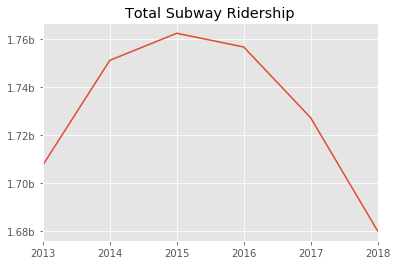

In [539]:
fig = plt.figure()
total = {}
total['index'] = [0]
total['13'] = df['2013'].sum()
total['14'] = df['2014'].sum()
total['15'] = df['2015'].sum()
total['16'] = df['2016'].sum()
total['17'] = df['2017'].sum()
total['18'] = df['2018'].sum()
total = pd.DataFrame(total)
total = total.transpose()
ax = total.tail(6).plot(kind='line', legend=False)
ax.set_title('Total Subway Ridership')
# ax.set_ylim([1670000000, 1780000000])
ax.set_yticklabels(['','1.68b','1.70b','1.72b','1.74b','1.76b','1.78b'])
ax.set_xticklabels(['2013','2014','2015','2016','2017','2018'], rotation='horizontal')
# ax.patch.set_facecolor('lightgray')

# # plt.plot(range(10))
# plt.axvspan(4, 5, color='goldenrod', alpha=0.3)
# plt.show()


plt.savefig("C:/Users/sawye/Desktop/reporting/enterprise/total_ridership_drop.svg", bbox_inches='tight')

[]

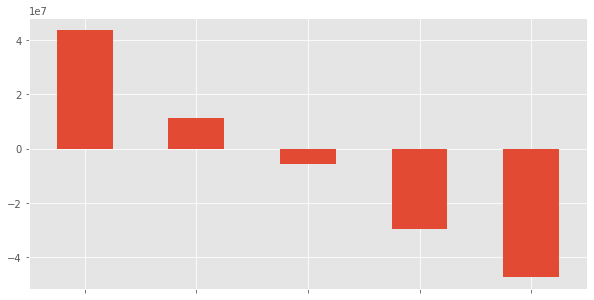

In [540]:
total={}
total['index'] = [0]
total['13-14'] = (df['2014'].sum() - df['2013'].sum())
total['14-15'] = (df['2015'].sum() - df['2014'].sum()) 
total['15-16'] = (df['2016'].sum() - df['2015'].sum())
total['16-17'] = (df['2017'].sum() - df['2016'].sum())
total['17-18'] = (df['2018'].sum() - df['2017'].sum())
total = pd.DataFrame(total)
total = total.transpose()
ax=total.tail(5).plot(kind='bar',legend=False, figsize=(10,5))
# ax.set_yticklabels(['','','-40m','-20m','0','20m','40m'])
ax.set_xticklabels('')

# plt.savefig("images/header_image.pdf")

##  Total ridership by borough

In [542]:
df.groupby('Borough').sum()

,Rank,2013,2014,2015,2016,2017,2018,17-18 change
Borough,,,,,,,,
Brooklyn,39254,372392182.0,382724843.0,387548598.0,384540220.0,379372550.0,370231302,-9141248.0
Manhattan,14537,940342922.0,965303064.0,970332468.0,966394667.0,955572737.0,936516980,-20301212.0
Queens,18895,245692630.0,250683329.0,252328123.0,252780951.0,243113483.0,234085767,-9027716.0
The Bronx,17414,149111695.0,152510555.0,152317861.0,153079012.0,149220838.0,139238932,-9981906.0


In [543]:
df.Borough.value_counts().keys()

CategoricalIndex(['Brooklyn', 'Manhattan', 'Queens', 'The Bronx'], categories=['Brooklyn', 'Manhattan', 'Queens', 'The Bronx'], ordered=False, dtype='category')

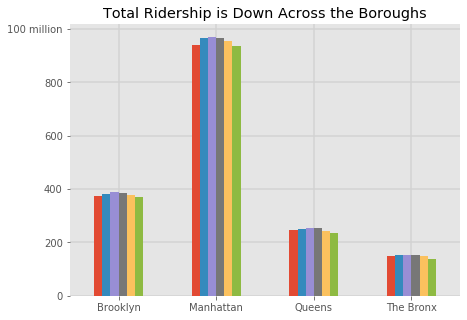

In [544]:
ax = df.groupby('Borough').sum().plot(kind='bar', y=['2013','2014','2015','2016','2017','2018'], figsize=(7, 5), legend=False)
ax.set_xlabel('')
ax.set_title('Total Ridership is Down Across the Boroughs')
ax.set_xticklabels(labels=df.Borough.value_counts().keys(),rotation='horizontal')
ax.set_yticklabels([0,200,400,600,800,'100 million'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color='lightgray', linestyle='-', linewidth=1.5)

## Total loss per borough per year

In [669]:
## sum of each borough dataframe
df2={}
df2['borough'] = ['Brooklyn','Manhattan','Queens','The Bronx']
df2['13-14'] = (df.groupby('Borough')['2014'].sum().values - df.groupby('Borough')['2013'].sum().values)
df2['14-15'] = (df.groupby('Borough')['2015'].sum().values - df.groupby('Borough')['2014'].sum().values)
df2['15-16'] = (df.groupby('Borough')['2016'].sum().values - df.groupby('Borough')['2015'].sum().values)
df2['16-17'] = (df.groupby('Borough')['2017'].sum().values - df.groupby('Borough')['2016'].sum().values)
df2['17-18'] = (df.groupby('Borough')['2018'].sum().values - df.groupby('Borough')['2017'].sum().values)
df2 = pd.DataFrame(df2)

def cat_boro(x):
    if x.borough == "Manhattan":
        return 1
    elif x.borough == "Brooklyn":
        return 2
    elif x.borough == "Queens":
        return 3
    else:
        return 4
df2['Borough Category'] = df2.apply(cat_boro, axis=1)

df2 = df2.sort_values('Borough Category')

df2.head()
# df.groupby('Borough').Station.count().values

,borough,13-14,14-15,15-16,16-17,17-18,Borough Category
1,Manhattan,24960142.0,5029404.0,-3937801.0,-10821930.0,-19055757.0,1
0,Brooklyn,10332661.0,4823755.0,-3008378.0,-5167670.0,-9141248.0,2
2,Queens,4990699.0,1644794.0,452828.0,-9667468.0,-9027716.0,3
3,The Bronx,3398860.0,-192694.0,761151.0,-3858174.0,-9981906.0,4


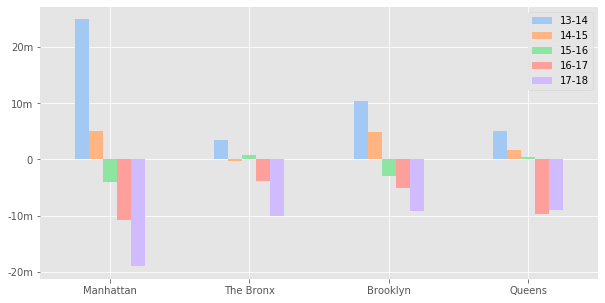

In [667]:
ax = df2.plot(kind='bar', x='borough', y=['13-14','14-15','15-16','16-17','17-18'], figsize=(10,5))
ax.set_xlabel('')
ax.set_yticklabels(['','-20m','-10m','0','10m','20m'])
ax.set_xticklabels(df2.borough, rotation='horizontal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig("img/annual_ridership_by_borough_2.svg", bbox_inches='tight')

In [682]:
def build_colors(x):
    if x['13-14'] > 0 :
        return '#E5E5E5'
    else:
        return '#FD9E9A'
colors = df2.reset_index().apply(build_colors, axis=1)
colors

0    #E5E5E5
1    #E5E5E5
2    #E5E5E5
3    #E5E5E5
dtype: object

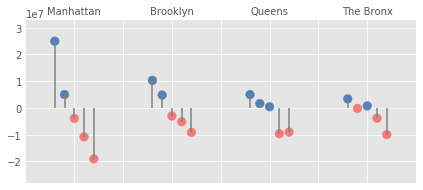

In [731]:
fig, ax = plt.subplots(figsize=(7,3))
ax.set_xlim([-1,7])
ax.set_ylim([-28000000, 33000000])
ax.xaxis.tick_top()
ax.set_xticklabels(['','Manhattan','','Brooklyn','','Queens','','The Bronx'])
# ax.set_yticklabels(['','-20m','-10m','0','10m','20m'])
# ax.set_title("The MTA's Summer of Hell has passed \n but the ridership is still in decline", ha='center')

def build_colors(x):
    if x['13-14'] < 0 :
        return 'F07B7B'
    else:
        return '5580B6'
colors = df2.reset_index().apply(build_colors, axis=1)
ax.vlines(ymin=0, ymax=df2['13-14'], x=[(0-.4), (2-.4), (4-.4), (6-.4)], color='gray')
legend = [ax.scatter(y=df2['13-14'], x=[(0-.4), (2-.4), (4-.4), (6-.4)], s=75, color=("#"+colors))]

def build_colors(x):
    if x['14-15'] < 0 :
        return 'F07B7B'
    else:
        return '5580B6'
colors = df2.reset_index().apply(build_colors, axis=1)
ax.vlines(ymin=0, ymax=df2['14-15'], x=[(0-.2), (2-.2), (4-.2), (6-.2)], color='gray')
legend = [ax.scatter(y=df2['14-15'], x=[(0-.2), (2-.2), (4-.2), (6-.2)], s=75, color=("#"+colors))]

def build_colors(x):
    if x['15-16'] < 0 :
        return 'F07B7B'
    else:
        return '5580B6'
colors = df2.reset_index().apply(build_colors, axis=1)
ax.vlines(ymin=0, ymax=df2['15-16'], x=[(0), (2), (4), (6)], color='gray')
legend = [ax.scatter(y=df2['15-16'], x=[(0), (2), (4), (6)], s=75, color=("#"+colors))]

def build_colors(x):
    if x['16-17'] < 0 :
        return 'F07B7B'
    else:
        return '5580B6'
colors = df2.reset_index().apply(build_colors, axis=1)
ax.vlines(ymin=df2['16-17'], ymax=0, x=[(0+.2), (2+.2), (4+.2), (6+.2)], color='gray')
legend = [ax.scatter(y=df2['16-17'], x=[(0+.2), (2+.2), (4+.2), (6+.2)], s=75, color=("#"+colors))]

def build_colors(x):
    if x['17-18'] < 0 :
        return 'F07B7B'
    else:
        return '5580B6'
colors = df2.reset_index().apply(build_colors, axis=1)
ax.vlines(ymin=df2['17-18'], ymax=0, x=[(0+.4), (2+.4), (4+.4), (6+.4)], color='gray')
legend = [ax.scatter(y=df2['17-18'], x=[(0+.4), (2+.4), (4+.4), (6+.4)], s=75, color=("#"+colors))]


# three_four = mpatches.Patch(color='#5E8066', label='2013-14')
# four_five = mpatches.Patch(color='#8EBF99', label='2014-15')
# five_six = mpatches.Patch(color='#7bccc4', label='2015-16')
# six_seven = mpatches.Patch(color='#43a2ca', label='2016-17')
# seven_eight = mpatches.Patch(color='#2c7bb6', label="2017-18")
# ax.legend(handles=[three_four, four_five,five_six,six_seven,seven_eight], bbox_to_anchor=(1, 1))

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0)

# plt.figtext(.05,.04,"Graphic | Sawyer Click")
# plt.figtext(.05,.0,"Source | MTA")

plt.savefig("ugly/annual_drops_by_borough_original.pdf", bbox_inches='tight')

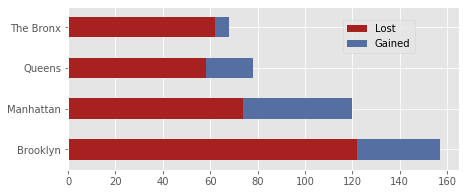

In [549]:
r = [0,1,2,3,4]
stacked_raw = {}
stacked_raw['index'] = [0, 1, 2, 3]
stacked_raw['Gained'] = (df[df['17-18 change'] > 0].groupby('Borough').Station.count())
stacked_raw['Lost'] = (df[df['17-18 change'] < 0].groupby('Borough').Station.count())
stacked = pd.DataFrame(stacked_raw)

ax = stacked.plot(kind='barh', y=['Lost','Gained'], stacked=True, color=['#a82121','#566FA3'], figsize=(7,3))
ax.legend( bbox_to_anchor=(.9, .95))
ax.set_ylabel('')
plt.savefig('img/lost_vs_gained.svg', bbox_inches='tight',transparent=True)

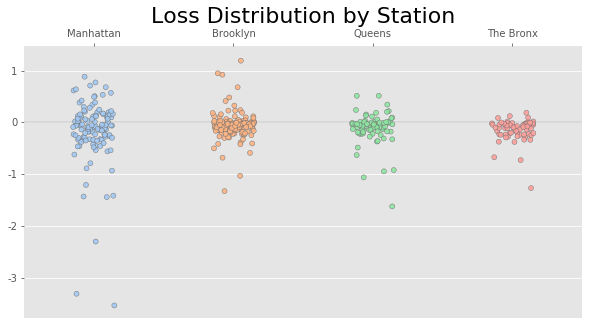

In [733]:
df = pd.read_csv('data/scraped_subway_ridership.csv', dtype=dtypes)

def cat_boro(x):
    if x.Borough == "Manhattan":
        return 1
    elif x.Borough == "Brooklyn":
        return 2
    elif x.Borough == "Queens":
        return 3
    else:
        return 4
df['Borough Category'] = df.apply(cat_boro, axis=1)

# df = df.sort_values('Borough Category', ascending=False)


fig, ax = plt.subplots(figsize=(10,5), dpi= 72)    

# df['17-18 change'] / 
sns.stripplot(df['Borough Category'],df['17-18 change'], jitter=.15, size=5, linewidth=.5, alpha=.9, palette=sns.set_palette('pastel'))
plt.axhline(0, color='lightgray')
# plt.axhline(df[df.Borough == 'Manhattan']['17-18 change'].mean(), xmin=.025, xmax=.225, color='black')
# plt.axhline(df[df.Borough == 'Brooklyn']['17-18 change'].mean(), xmin=.265, xmax=.49, color='black')
# plt.axhline(df[df.Borough == 'Manhattan']['17-18 change'].mean(), xmin=.525, xmax=.725, color='black')
# plt.axhline(df[df.Borough == 'The Bronx']['17-18 change'].mean(), xmin=.75, xmax=.975, color='black')

plt.title('Loss Distribution by Station', fontsize=22)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(['Manhattan','Brooklyn','Queens','The Bronx'])
ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(['','-3','-2','-1','0','1'])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig("ugly/manhattan_fell_the_hardest_original.pdf", bbox_inches='tight')

# Line by line

In [ ]:
# group the lines and create a new df

lines = ['1','2','3','4','5','6','7','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W','Z']
lines_df = []
for line in lines:
    line_one = df[df.lines.str.contains(line)]
    
    count = 13
    for year in range(0,5):
        total = {}
        total['line'] = line
        new = line_one[f"20{count + 1}"].sum()
        old = (line_one[f"20{count}"].sum())
        total['riders'] = ((new - old) / old) * 100
        total['years'] = f"{count}-{count+1}"
        lines_df.append(total)
        count = count + 1
    
lines_df = pd.DataFrame(lines_df)
lines_df[lines_df.line == '1'].riders[-1:] > 0 

# Lines w/ ridership growth

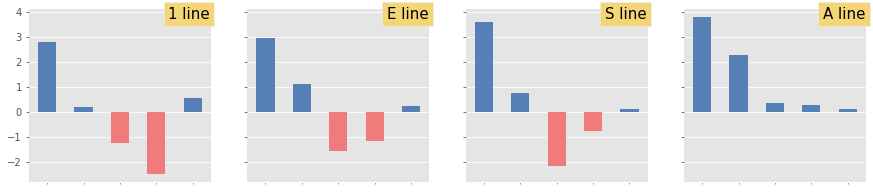

In [942]:
## Working template

## FILTER
positive = lines_df[(lines_df.years == "17-18") & (lines_df.riders > 0)].sort_values('riders', ascending=False).line

## For small multiple
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(15,7))
axes_list = [item for sublist in axes for item in sublist] 

for line in positive:
    ax = axes_list.pop(0)
    
    def build_colors(x):
        if x.riders < 0:
            return 'F07B7B'#red
        else:
            return '5580B6'#blue
    colors = lines_df[lines_df.line == line].reset_index().apply(build_colors, axis=1)
    
    ax=lines_df[lines_df.line == line].plot(kind='bar',x='years',y='riders', color="#"+colors, ax=ax,legend=False)
    
    ax.text(3.9, 3.9, f"{line} line", size=15,
         ha="center", va="center",
         bbox=dict(boxstyle="square",
                   fc=('#F4D678'),
                   )
         )
    plt.xticks([],[])
    
    ax.set_xlabel("")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in axes_list:
    ax.remove()
    
plt.savefig("ugly/17_18_ridership_gain.pdf", bbox_inches='tight')

In [792]:
positive = lines_df[lines_df['17-18'] > 0]
# ordered_positive = positive.sort_values('17-18',ascending=False)['line'].astype(str)
grouped = lines_df.groupby("line")

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10,4))
axes_list = [item for sublist in axes for item in sublist] 

for line in positive:
    ax = axes_list.pop(0)
    lines_df[lines_df['line'] == line].plot(ax=ax, legend=False)
    ax.set_title(line)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.grid(linewidth=0.25)
#     ax.set_xlim((1950, 2016))
    ax.set_xlabel("")
#     ax.set_xticks(range(1950, 2015, 25))
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()
# positive.plot()

for ax in axes_list:
    ax.remove()
# plt.tight_layout()


KeyError: '17-18'

TypeError: 'AxesSubplot' object is not iterable

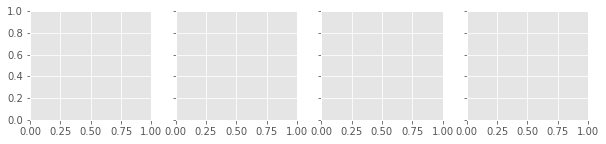

In [613]:
lines = ['1','2','3','4','5','6','7','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W','Z']

# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10,2))
axes_list = [item for sublist in axes for item in sublist] 

for line in lines:
    ax = axes_list.pop(0)
    if total['percentChange'] > 0:
        

        ax = lines_df.plot(kind='line', x='years',y='percentChange', ax=ax, title=line, legend=False, clip_on=False, color='blue')

        ax.tick_params(
            which='both',
            bottom='off',
            left='off',
            right='off',
            top='off'
        )
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis=u'both', which=u'both',length=0)
        ax.set_ylim(.15,.18)
        ax.set_xticklabels(['2013','','','','','2018'])
        ax.set_yticklabels(['15%','','','','','','18%'])
        ax.set_ylabel('')
        ax.set_xlabel('')
    
#     ax.set_ylim[total.riders.min()-100, total.riders.max()+100]

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
plt.tight_layout()
    
plt.subplots_adjust(hspace=1)

In [759]:
total

,riders,year,17-18 change,percentage
0,95199708.0,2013,-2269927.0,0.156795
1,98577513.0,2014,-2269927.0,0.162359
2,101187797.0,2015,-2269927.0,0.166658
3,105046084.0,2016,-2269927.0,0.173012
4,104709019.0,2017,-2269927.0,0.172457
5,102439092.0,2018,-2269927.0,0.168719


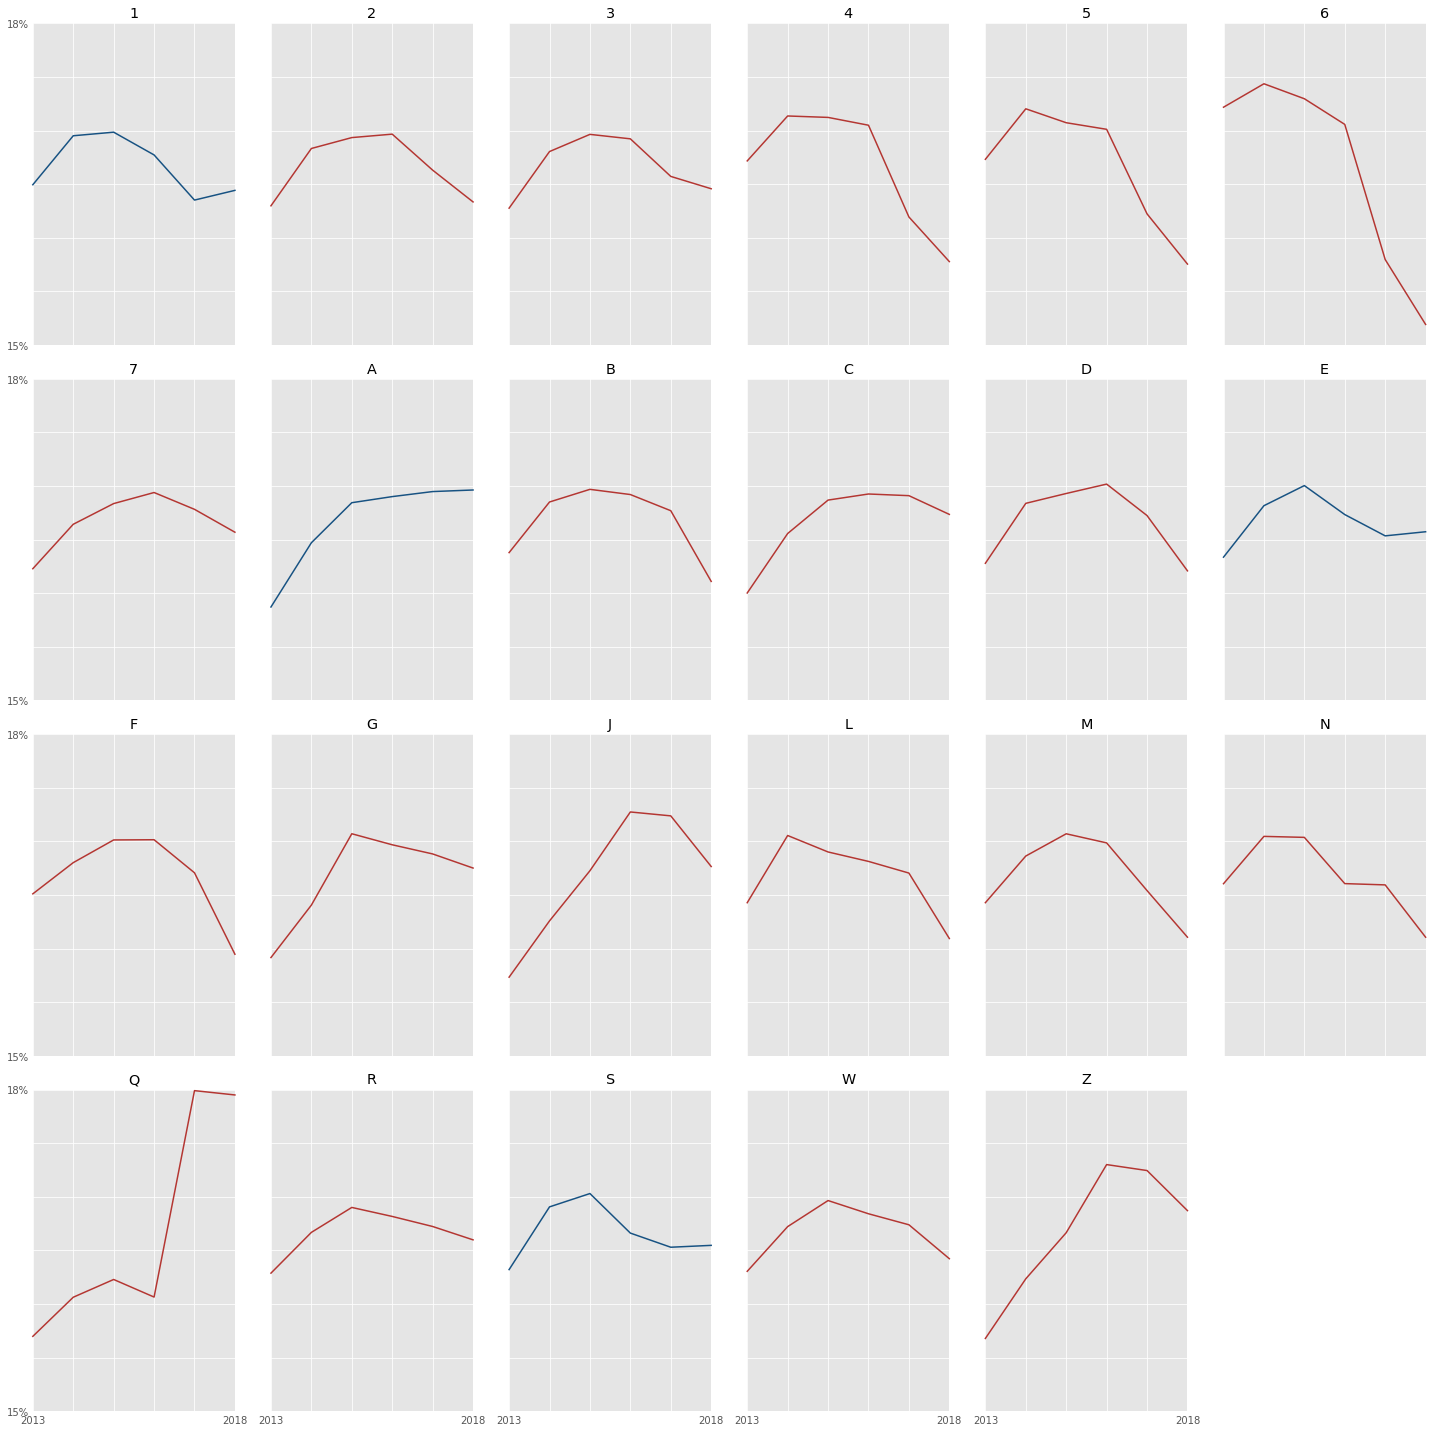

In [757]:
# Break them up

lines = ['1','2','3','4','5','6','7','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W','Z']

# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(20,20))
axes_list = [item for sublist in axes for item in sublist] 

for line in lines:
    line_one = df[df.lines.str.contains(line)]
    ax = axes_list.pop(0)
    
    total = {}
    total['riders'] = [line_one['2013'].sum(),line_one['2014'].sum(),line_one['2015'].sum(),line_one['2016'].sum(),line_one['2017'].sum(),line_one['2018'].sum()]
    total['year'] = ['2013','2014','2015','2016','2017','2018']
    total = pd.DataFrame(total)
    total['17-18 change'] = total.riders[5] - total.riders[4]

    if total['17-18 change'][5] > 0:
        color =  '#175282'
    else:
        color = '#B43632'
    
    def get_percentage(x):
        return x.riders / total['riders'].sum()

    total['percentage'] = total.apply(get_percentage, axis=1)

    ax = total.plot(kind='line', x='year',y='percentage', ax=ax, title=line, legend=False, clip_on=False, color=color)
    
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_ylim(.15,.18)
    ax.set_xticklabels(['2013','','','','','2018'])
    ax.set_yticklabels(['15%','','','','','','18%'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
#     ax.set_ylim[total.riders.min()-100, total.riders.max()+100]

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
plt.tight_layout()


# plt.subplots_adjust(hspace=1)
# plt.savefig("img/all_lines_ridership.pdf")

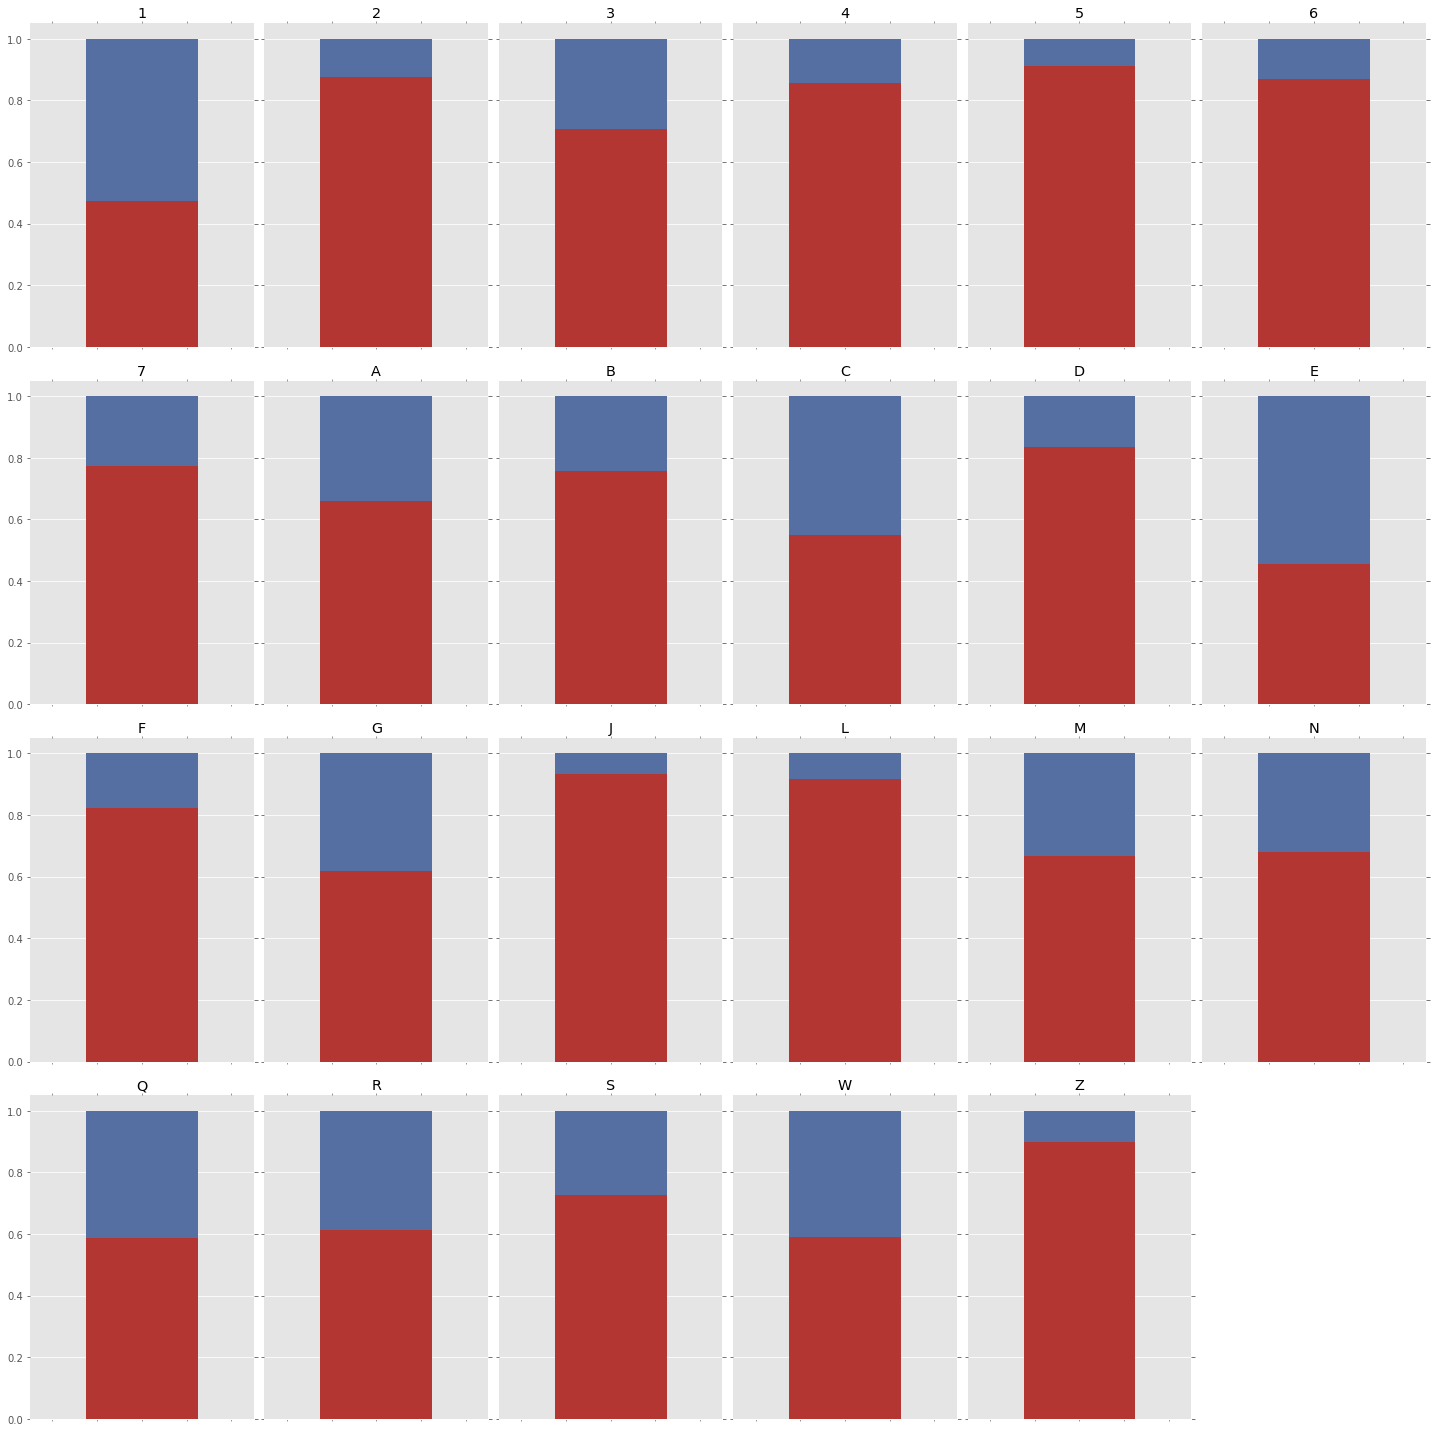

In [614]:
lines = ['1','2','3','4','5','6','7','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W','Z']

# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(20,20))
axes_list = [item for sublist in axes for item in sublist] 

for line in lines:
    line_one = df[df.lines.str.contains(line)]
    ax = axes_list.pop(0)
    
    count = {}
    count['index'] = [0]
    count['gained'] = ((line_one['17-18 change'] > 0).value_counts().sort_index().values[0]) / ((line_one['17-18 change'] > 0).value_counts().values.sum())
    count['lost'] = ((line_one['17-18 change'] > 0).value_counts().sort_index().values[1]) / ((line_one['17-18 change'] > 0).value_counts().values.sum())
    count = pd.DataFrame(count)
    
    count.plot(kind='bar', stacked=True, label=line, ax=ax, legend=False, color=['#566FA3','#B43632'])
    ax.set_title(line)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
    
plt.tight_layout()

In [97]:
addresses = pd.read_csv("C:/Users/sawye/Desktop/reporting/data/Stations.csv")

In [ ]:
df.to_csv("station_annual_ridership.csv", index=False)


<hr>
<hr>
<hr>

## Average weekday ridership
`http://web.mta.info/nyct/facts/ridership/ridership_sub.htm`

In [ ]:
response = requests.get("http://web.mta.info/nyct/facts/ridership/ridership_sub.htm")
doc = BeautifulSoup(response.text)

In [ ]:
stations = []
lines = ""
for row in doc.find_all("tr")[5:]:
    station = {}
    total = ""
    try:
        
        station['Station'] = row.find_all("td")[0].text.strip()        
        try: 
            for pic in row.find("td").find("div").find_all("img"):
                one = pic['alt'].split(" ")[0]
                total = one + total
                station['lines'] = total
        except:
            pass

        station['2013'] = row.find_all("td")[1].text
        station['2014'] = row.find_all("td")[2].text
        station['2015'] = row.find_all("td")[3].text
        station['2016'] = row.find_all("td")[4].text
        station['2017'] = row.find_all("td")[5].text
        station['2018'] = row.find_all("td")[6].text.strip()
        station['Rank'] = row.find_all("td")[9].text
        station['Borough'] = row.find_previous("td", colspan="10").text
        stations.append(station)
    except: pass

In [ ]:
weekday = pd.DataFrame(stations, columns=['Station','lines','Borough','Rank','2013','2014','2015','2016','2017','2018'])
weekday = weekday.dropna()

## Changing the numbers to actual numbers
cols = ['2013', '2014','2015','2016','2017','2018']
weekday[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
weekday.Rank = weekday.Rank.astype(int)
weekday['change'] = weekday['2018'] - weekday['2017']

In [ ]:
weekday.groupby('Borough').max().plot(kind='barh', y='2018')

In [ ]:
weekday.groupby('Borough')['2018'].min()

In [ ]:
df['change'] = df['2018'] - df['2017']

In [ ]:
df.to_csv("station_weekday_ridership.csv", index=False)

## Average Weekend Ridership
`http://web.mta.info/nyct/facts/ridership/ridership_sub_weekend.htm`

In [ ]:
response = requests.get("http://web.mta.info/nyct/facts/ridership/ridership_sub_weekend.htm")
doc = BeautifulSoup(response.text)

In [ ]:
stations = []
lines = ""
for row in doc.find_all("tr")[5:]:
    station = {}
    total = ""
    try:
        
        station['Station'] = row.find_all("td")[0].text.strip()        
        try: 
            for pic in row.find("td").find("div").find_all("img"):
                one = pic['alt'].split(" ")[0]
                total = one + total
                station['lines'] = total
        except:
            pass

        station['2013'] = row.find_all("td")[1].text
        station['2014'] = row.find_all("td")[2].text
        station['2015'] = row.find_all("td")[3].text
        station['2016'] = row.find_all("td")[4].text
        station['2017'] = row.find_all("td")[5].text
        station['2018'] = row.find_all("td")[6].text.strip()
        station['Rank'] = row.find_all("td")[9].text
        station['Borough'] = row.find_previous("td", colspan="10").text
        stations.append(station)
    except: pass

In [ ]:
df = pd.DataFrame(stations, columns=['Station','lines','Borough','Rank','2013','2014','2015','2016','2017','2018'])
df = df.dropna()

## Changing the numbers to actual numbers
cols = ['2013', '2014','2015','2016','2017','2018']
df[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
df.Rank = df.Rank.astype(int)

In [ ]:
df.tail()

In [ ]:
ax = df.groupby(by='Borough')['2017'].sum().plot(kind='barh', alpha=.5, color='red', title='Ridership change from 2018 to 2017', figsize=(7,5))
df.groupby(by='Borough')['2018'].sum().plot(kind='barh', ax=ax, color='gray')

In [ ]:
df.to_csv("station_weekend_ridership.csv", index=False)